## Punto 2
Importar datos

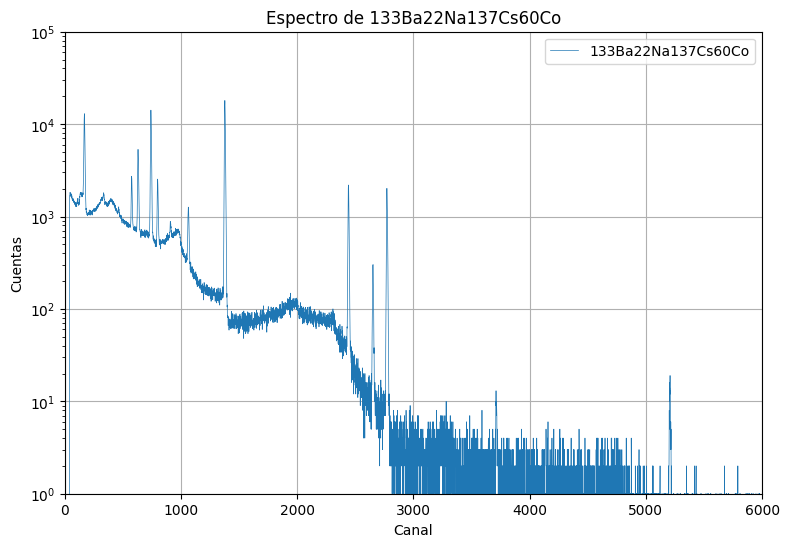

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# datos de calibración
# data_cal = np.loadtxt('files/calibracion.txt')
# importar datos csv con encabezados

data_cal = np.genfromtxt('2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv', delimiter=',', skip_header=1)
canales = data_cal[:,0]
cuentas = data_cal[:,1]
fuente = '133Ba22Na137Cs60Co'

# La fuente de calibración es Ba-133, Na-22, Cs-137 y Co-60
def plotear_espectro(canales, cuentas, fuente, xlim=None, logplot=True, size=(9, 6)):
    plt.figure(figsize=size)
    plt.plot(canales, cuentas, label=fuente, linewidth=0.5)
    plt.xlabel('Canal')
    plt.ylabel('Cuentas')
    plt.title(f'Espectro de {fuente}')
    plt.grid()
    if logplot:
        plt.yscale('log')
        plt.ylim(1, 10**(np.ceil(np.log10(max(cuentas)))))
    else:
        plt.ylim(1, max(cuentas)+100)
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, max(canales))
    plt.legend()
    plt.show()

plotear_espectro(canales, cuentas, fuente, xlim=6000)
# plotear_espectro(canales, cuentas, fuente, xlim=6000, logplot=False)

In [2]:
# lista de energías de los picos de calibración

values = {'22Na_1': 1274.537,
             '60Co_1': 1173.228,
             '60Co_2': 1332.490,
             '137Cs_1': 661.657,
             '137Cs_alfa':32.06,
             '133Ba_1': 53.1625,
             '133Ba_2': 79.6139,
             '133Ba_3': 80.9971,
             '133Ba_4': 160.6109,
             '133Ba_5': 223.2373,
             '133Ba_6': 276.3997,
             '133Ba_7': 302.8510,
             '133Ba_8': 356.0134,
             '133Ba_9': 383.8480}


values_sorted = sorted(values.items(), key=lambda x: x[1])

p_energia = [(key, value) for key, value in values_sorted if key not in ['137Cs_alfa', '137Cs_beta', '133Ba_1', '133Ba_2', '133Ba_4', '133Ba_5']]

import pandas as pd
f_calibracion = pd.DataFrame(p_energia, columns=['Fuente', 'E_gamma (keV)'])
f_calibracion


,Fuente,E_gamma (keV)
0,133Ba_3,80.9971
1,133Ba_6,276.3997
2,133Ba_7,302.8510
3,133Ba_8,356.0134
4,133Ba_9,383.8480
5,137Cs_1,661.6570
6,60Co_1,1173.2280
7,22Na_1,1274.5370
8,60Co_2,1332.4900


In [3]:
#Funcion para plotear un pico de interés
def plotear_pico(canales, cuentas, fuente, canal, anchocanal=20, logplot=True):
    plt.figure(figsize=(8, 3))
    plt.plot(canales, cuentas, label=fuente)
    plt.xlabel('Canal')
    plt.ylabel('Cuentas')
    plt.title(f'Espectro de {fuente}')
    if logplot:
        plt.yscale('log')
    plt.grid()
    plt.xlim(canal-anchocanal, canal+anchocanal)
    plt.legend()
    plt.show()

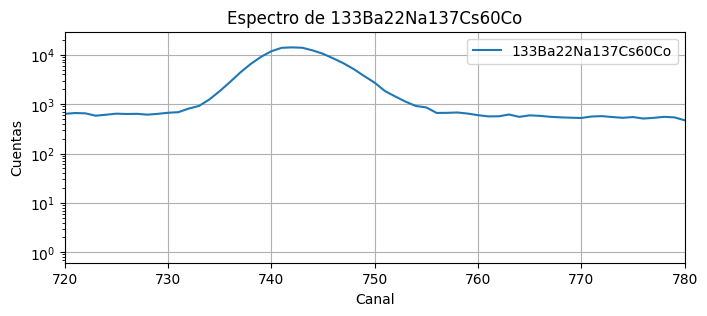

In [4]:
# Lista de canales de los picos de calibración

plotear_pico(canales, cuentas, fuente, 750, anchocanal=30)

In [5]:
#funcion para plotear canal energia en un mismo scatter
def plot_canal_energia(data, canal):
   
    fig, ax1 = plt.subplots()

    energia = data['E_gamma (keV)']

    ax1.scatter(range(len(canal)), canal, color='red', label='Canal estimado')
    ax1.set_ylabel('p_canal_estimado')

    ax2 = ax1.twinx()

    ax2.scatter(range(len(energia)), energia, color='blue',marker='x', label='Energia')
    ax2.set_ylabel('p_energia')

    ax1.set_xticks(range(max([len(energia),len(canal)])))
    ax1.set_xticklabels(range(max([len(energia),len(canal)])))

    ax1.legend(loc='upper left')
    ax2.legend(loc='center left')

    plt.show()

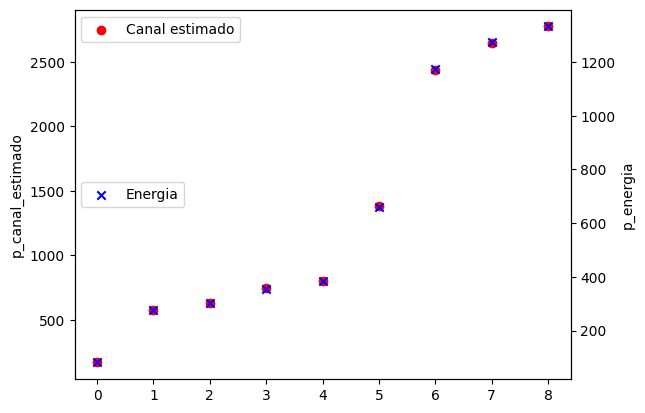

In [6]:

p_canal_estimado = [170, 575, 630, 745, 800, 1380, 2440, 2650, 2775]

# ir recortando valores de energia hasta que las graficas se correspondan
plot_canal_energia(f_calibracion, p_canal_estimado)

In [7]:
# agregar las energias a sus respectivos picos añadiendolos al dataframe

f_calibracion['Canal estimado'] = p_canal_estimado
f_calibracion

,Fuente,E_gamma (keV),Canal estimado
0,133Ba_3,80.9971,170
1,133Ba_6,276.3997,575
2,133Ba_7,302.8510,630
3,133Ba_8,356.0134,745
4,133Ba_9,383.8480,800
5,137Cs_1,661.6570,1380
6,60Co_1,1173.2280,2440
7,22Na_1,1274.5370,2650
8,60Co_2,1332.4900,2775


In [8]:
# Funciones gaussianas para el ajuste de los picos

def gaussiana_lineal(x, a, x0, sigma, b_0, b_1):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b_0 + b_1*x

def gaussiana(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
# Se define un rango de ajuste para cada fotopico


In [9]:
# Ajuste de gaussiana al rededor de cada fotopico de e_canal_cal

from scipy.optimize import curve_fit
def ajustar_gaussiana_lineal(data, canales, cuentas):
    rango_ajuste = [(c-30, c+30) for c in data['Canal estimado']]
    # Se define un rango de ajuste para cada fotopico
    # los parametros optimos son guardados en popt y la covarianza en pcov
    # popt_i = [a, x0, sigma] para el i-esimo fotopico
    # pcov_i = matriz de covarianza para el i-esimo fotopico
    # a = amplitud, x0 = centro, sigma = desviacion estandar
    popt = []
    pcov = []
    for i in range(len(rango_ajuste)):
        popt_i, pcov_i = curve_fit(gaussiana_lineal, canales[rango_ajuste[i][0]:rango_ajuste[i][1]], cuentas[rango_ajuste[i][0]:rango_ajuste[i][1]], p0=[max(cuentas[rango_ajuste[i][0]:rango_ajuste[i][1]]), f_calibracion['Canal estimado'][i], 10, 0, 0])
        popt.append(popt_i)
        pcov.append(pcov_i)

    incertidumbres = np.sqrt(np.diagonal(pcov, axis1=1, axis2=2))

    data['A (cuentas)'] = [round(popt_i[0],2) for popt_i in popt]
    data['dA (cuentas)'] = [round(incertidumbres_i[0],2) for incertidumbres_i in incertidumbres]
    data['Canal'] = [round(popt_i[1],2) for popt_i in popt]
    data['dCanal'] = [round(incertidumbres_i[1],2) for incertidumbres_i in incertidumbres]
    data['sigma (Canales)'] = [round(popt_i[2],2) for popt_i in popt]
    data['dSigma (Canales)'] = [round(incertidumbres_i[2],2) for incertidumbres_i in incertidumbres]

    return f_calibracion

f_calibracion = ajustar_gaussiana_lineal(f_calibracion, canales, cuentas)
f_calibracion

,Fuente,E_gamma (keV),Canal estimado,A (cuentas),dA (cuentas),Canal,dCanal,sigma (Canales),dSigma (Canales)
0,133Ba_3,80.9971,170,11169.65,88.82,170.07,0.03,3.55,0.03
1,133Ba_6,276.3997,575,1899.16,22.38,576.79,0.05,3.42,0.05
2,133Ba_7,302.8510,630,4550.64,48.73,631.85,0.04,3.58,0.05
3,133Ba_8,356.0134,745,13494.56,136.65,742.45,0.04,3.57,0.04
4,133Ba_9,383.8480,800,1921.73,21.87,800.33,0.05,3.62,0.05
5,137Cs_1,661.6570,1380,17574.63,150.32,1378.20,0.04,3.60,0.04
6,60Co_1,1173.2280,2440,2158.12,18.05,2441.69,0.04,3.74,0.04
7,22Na_1,1274.5370,2650,290.65,3.85,2652.08,0.05,3.63,0.06
8,60Co_2,1332.4900,2775,1917.39,24.79,2772.46,0.06,3.78,0.06


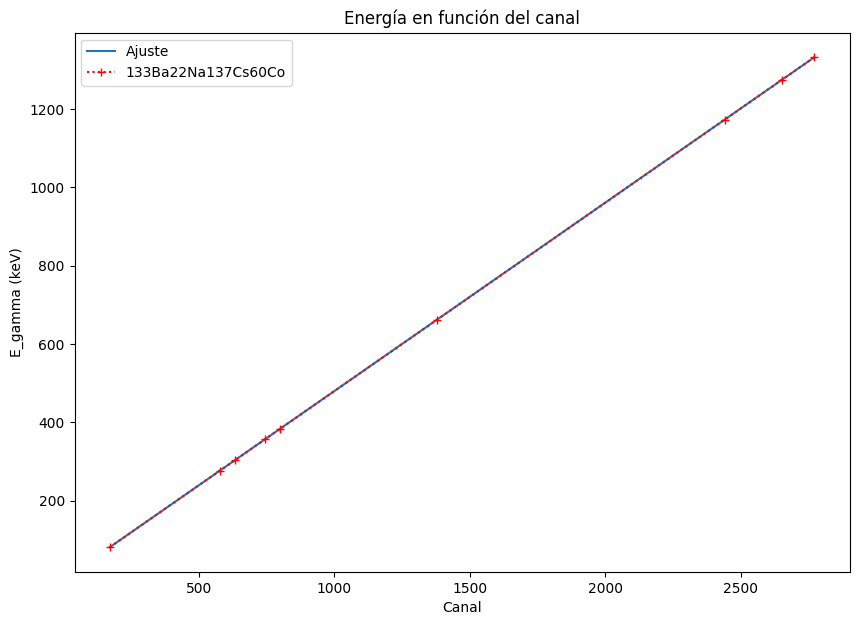

,parametro,valor,incertidumbre
0,a_1,0.480936,0.000042
1,a_0,-1.001274,0.068993


In [10]:
# Ajuste lineal Energia vs Canal

from scipy.stats import linregress

a_1, a_0, r_value, p_value, std_err = linregress(f_calibracion['Canal'], f_calibracion['E_gamma (keV)'])

# Los errores de la pendiente y la ordenada al origen son:

incert_a_1 = std_err
incert_a_0 = std_err*np.sqrt(np.mean(f_calibracion['Canal']**2))

# plot the adjusted values of the counts for each channel
plt.figure(figsize=(10, 7))
plt.plot(f_calibracion['Canal'], a_1*f_calibracion['Canal']+a_0, label='Ajuste')
plt.plot(f_calibracion['Canal'], f_calibracion['E_gamma (keV)'], 'r+:', label=fuente)
plt.xlabel('Canal')
plt.ylabel('E_gamma (keV)')
plt.title('Energía en función del canal')
plt.legend()
plt.show()


data3 = {
    'parametro' : ['a_1', 'a_0'],
    'valor' : [a_1, a_0],
    'incertidumbre' : [incert_a_1, incert_a_0]
}

df_3 = pd.DataFrame(data3)
df_3

## Punto 3
Da información del experimento

## Punto 4
importar datos

In [11]:
def plot_espectro_kev(canales, energia, fuente, xlim=None, logplot=True, size=(9, 6)):
    plt.figure(figsize=size)
    plt.plot(canales, energia, label=fuente, linewidth=0.5)
    plt.xlabel('Energia (keV)')
    plt.ylabel('Cuentas')
    plt.title(f'Espectro de {fuente}')
    plt.grid()
    if logplot:
        plt.yscale('log')
        plt.ylim(1, 10**(np.ceil(np.log10(max(energia)))))
    else:
        plt.ylim(1, max(energia)+100)
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, max(canales))
    plt.legend()
    plt.show()

## Punto 5

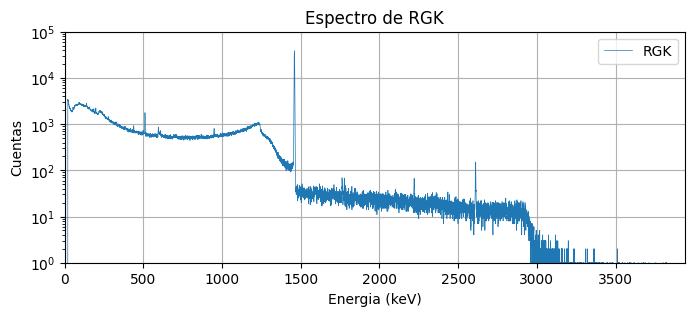

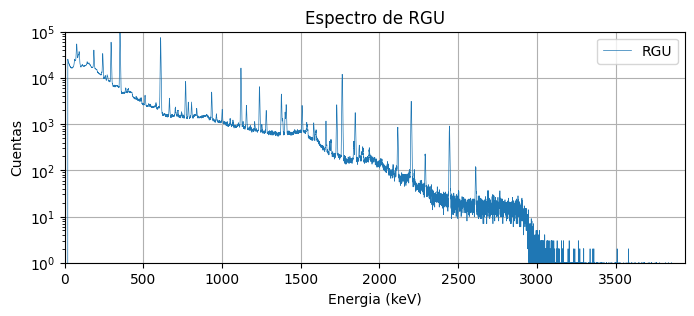

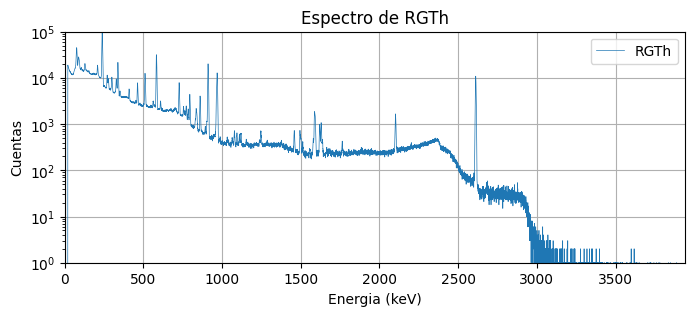

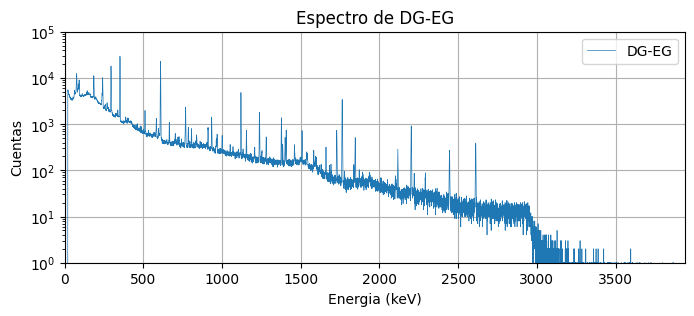

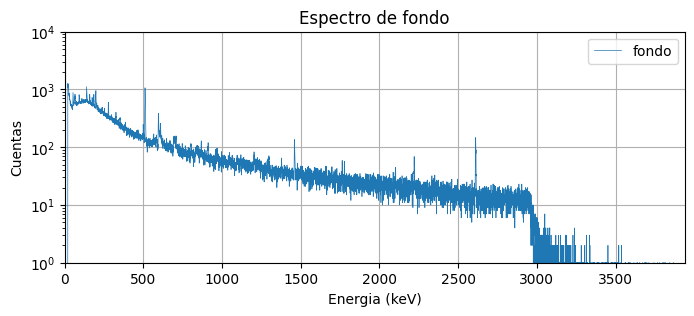

,Canal,Energía (keV),RGK,RGU,RGTh,DG-EG,fondo
1000,1000.0,479.935036,648.0,3705.0,2659.0,911.0,150.0
1001,1001.0,480.415972,605.0,3541.0,2696.0,899.0,140.0
1002,1002.0,480.896908,629.0,3571.0,2668.0,857.0,163.0
1003,1003.0,481.377844,632.0,3491.0,2534.0,777.0,135.0
1004,1004.0,481.858781,626.0,3350.0,2612.0,760.0,148.0


In [12]:
#importa los datos de los espectros de las muestras y el fondo
nombre_datos = ['RGK', 'RGU', 'RGTh','DG-EG','fondo']
archivos = ['2021-11-17_mue_IAEA-RGK-1_24h.csv','2021-11-16_mue_IAEA-RGU-1_24h.csv','2021-11-15_mue_IAEA-RGTh-1_24h.csv','2021-12-04_mue_DG-EG-014_24h.csv','2021-12-15_fon_24h.csv']

# importar datos csv con encabezados en e_medido (espectro medido)
e_medido = pd.DataFrame()
e_medido['Canal'] = canales
e_medido['Energía (keV)'] = a_1*e_medido['Canal'] + a_0

for i in range(len(archivos)):
    data_i = np.genfromtxt(archivos[i], delimiter=',', skip_header=1)
    # canales_i = data_i[:,0]
    cuentas_i = data_i[:,1]
    fuente_i = nombre_datos[i]
    plot_espectro_kev(e_medido['Energía (keV)'], cuentas_i, fuente_i, size=(8, 3))
    e_medido[nombre_datos[i]] = cuentas_i

e_medido.iloc[1000:1005]

In [13]:
# Remover el fondo de los espectros de las muestras e_puro (espectro puro)

e_puro = pd.DataFrame()
e_puro['Canal'] = canales
e_puro['Energía (keV)'] = e_medido['Energía (keV)']
for i in range(len(nombre_datos)-1):
    e_puro[nombre_datos[i]] = e_medido[nombre_datos[i]] - e_medido['fondo']

e_puro.iloc[1000:1005]

,Canal,Energía (keV),RGK,RGU,RGTh,DG-EG
1000,1000.0,479.935036,498.0,3555.0,2509.0,761.0
1001,1001.0,480.415972,465.0,3401.0,2556.0,759.0
1002,1002.0,480.896908,466.0,3408.0,2505.0,694.0
1003,1003.0,481.377844,497.0,3356.0,2399.0,642.0
1004,1004.0,481.858781,478.0,3202.0,2464.0,612.0


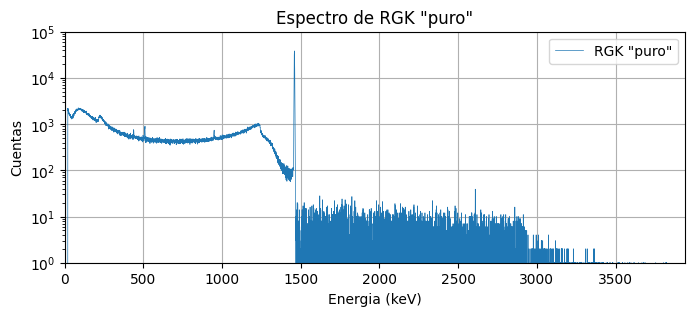

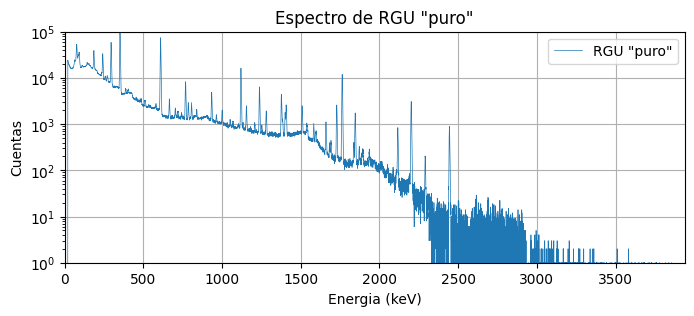

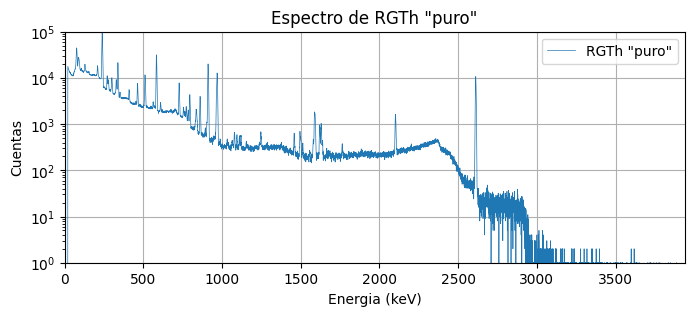

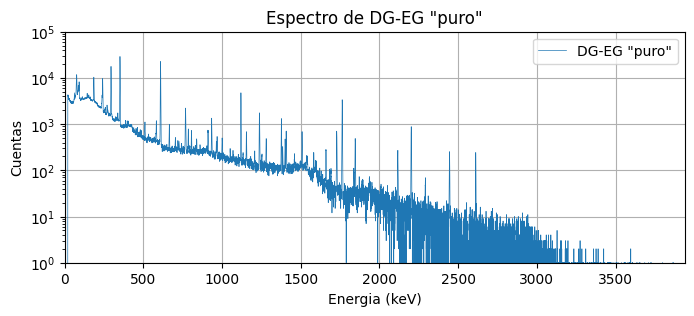

In [14]:
# Plotea los espectros puros
for i in range(len(archivos)-1):
    plot_espectro_kev(e_puro['Energía (keV)'], e_puro[nombre_datos[i]], nombre_datos[i]+' \"puro\"', size=(8, 3))


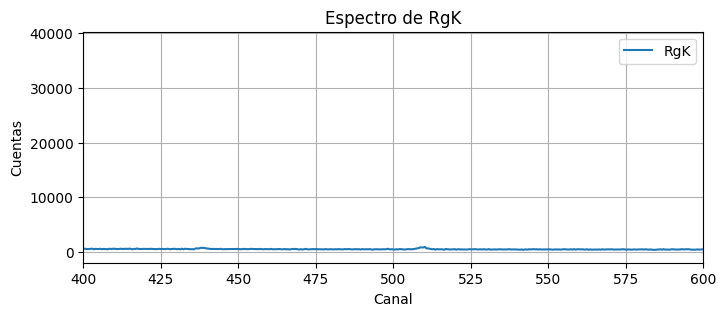

In [15]:
# Plotea picos para facilitar la estimación del canal
plotear_pico(e_puro['Energía (keV)'], e_puro['RGK'], 'RgK', 500, anchocanal=100, logplot=False)

# Analisis y resultados
## Punto 2

In [57]:
# importar datos csv de los fotopicos estimados

data = np.genfromtxt('fotopicos.csv', delimiter=',')

sort_indices = np.argsort(data[:,1])
data_sorted = data[sort_indices]
n_ref,p_e_estimada = data_sorted[:,0],data_sorted[:,1]
p_c_estimado = [np.round((e-a_0)/a_1,0) for e in p_e_estimada]

string_data = [f"({a},{b})," for a, b in data]
#guardar los datos en un txt
with open('fotopicos.txt', 'w') as f:
    f.write('\n'.join(string_data))

p_adj = pd.DataFrame()
p_adj['Fuente'] = [nombre_datos[int(n_ref_i)-1] for n_ref_i in n_ref]
p_adj['E Estimada'] = p_e_estimada
p_adj['Canal estimado'] = p_c_estimado

In [58]:
# Ajuste de gaussiana lineal a los espectros puros

rangos_ajuste = [(int(c-15), int(c+15)) for c in p_c_estimado]

popt2 = []
pcov2 = []

for i in range(len(p_c_estimado)):
    j = int(n_ref[i]-1)
    x = e_puro['Canal'][rangos_ajuste[i][0]:rangos_ajuste[i][1]]
    y = e_puro[nombre_datos[j]][rangos_ajuste[i][0]:rangos_ajuste[i][1]]
    popt_i, pcov_i = curve_fit(gaussiana_lineal, x, y, p0=[max(y), p_c_estimado[i], 10, 0, 0])
    popt2.append(popt_i)
    pcov2.append(pcov_i)

incertidumbres2 = np.sqrt(np.diagonal(pcov2, axis1=1, axis2=2))

p_adj['A (cuentas)'] = [round(popt_i[0],2) for popt_i in popt2]
p_adj['dA (cuentas)'] = [round(incertidumbres_i[0],2) for incertidumbres_i in incertidumbres2]
p_adj['Energía (Canal)'] = [round(popt_i[1],2) for popt_i in popt2]
p_adj['dE (Canal)'] = [round(incertidumbres_i[1],2) for incertidumbres_i in incertidumbres2]
p_adj['sigma (Canal)'] = [round(popt_i[2],2) for popt_i in popt2]
p_adj['dsigma (Canal)'] = [round(incertidumbres_i[2],2) for incertidumbres_i in incertidumbres2]
p_adj['b_0'] = [round(popt_i[3],2) for popt_i in popt2]
p_adj['db_0'] = [round(incertidumbres_i[3],2) for incertidumbres_i in incertidumbres2]
p_adj['b_1'] = [round(popt_i[4],2) for popt_i in popt2]
p_adj['db_1'] = [round(incertidumbres_i[4],2) for incertidumbres_i in incertidumbres2]


p_adj

,Fuente,E Estimada,Canal estimado,A (cuentas),dA (cuentas),Energía (Canal),dE (Canal),sigma (Canal),dsigma (Canal),b_0,db_0,b_1,db_1
0,RGTh,75.0,158.0,28035.65,285.88,160.60,0.05,4.96,0.07,17917.41,2338.07,-9.27,15.85
1,RGU,91.0,191.0,14642.17,2886.69,193.60,0.88,7.28,1.34,110198.58,20617.70,-467.49,120.05
2,RGTh,130.0,272.0,5658.06,92.45,270.54,0.08,4.59,0.11,9921.58,1247.72,15.15,4.53
3,RGU,185.0,387.0,22408.22,337.51,388.52,0.06,3.75,0.08,9699.17,5947.67,17.74,15.54
4,RGTh,210.0,439.0,7150.82,133.96,437.14,0.09,4.08,0.11,15069.35,2786.64,-9.11,6.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,RGU,2120.0,4410.0,782.88,36.11,4402.68,0.14,4.43,0.22,-10224.01,9615.08,2.33,2.18
71,RGU,2200.0,4576.0,2892.75,36.30,4580.11,0.05,3.94,0.07,-55179.20,9422.06,12.10,2.06
72,RGU,2290.0,4764.0,184.47,5.30,4764.98,0.13,3.92,0.15,38.24,1166.57,-0.00,0.25
73,RGU,2445.0,5086.0,842.05,15.35,5085.27,0.09,4.19,0.11,-6998.85,3636.55,1.38,0.71


In [59]:
# Perform the linear Gaussian fit using the same parameters

popt3 = []
pcov3 = []

for i in range(len(p_c_estimado)):
    x = e_puro['Canal'][rangos_ajuste[i][0]:rangos_ajuste[i][1]]
    y = e_puro['DG-EG'][rangos_ajuste[i][0]:rangos_ajuste[i][1]]
    popt_i, pcov_i = curve_fit(gaussiana_lineal, x, y, p0=[max(y), popt2[i][1], popt2[i][2], 0, 0], bounds=([0, popt2[i][1]-0.01, popt2[i][2]-0.01, -np.inf, -np.inf], [np.inf, popt2[i][1], popt2[i][2]+0.01, np.inf, np.inf]))
    popt3.append(popt_i)
    pcov3.append(pcov_i)

incertidumbres3 = np.sqrt(np.diagonal(pcov3, axis1=1, axis2=2))


c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_lsq\trf.py:234: RuntimeWarning: divide by zero encountered in true_divide
  Delta = norm(x0 * scale_inv / v**0.5)
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: invalid value encountered in double_scalars
  alpha *= Delta / Delta_new
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_lsq\common.py:49: RuntimeWarning: invalid value encountered in double_scalars
  t2 = c / q


In [60]:
p_adj['DG-EG A (cuentas)'] = [round(popt_i[0],2) for popt_i in popt3]
p_adj['DG-EG dA (cuentas)'] = [round(incertidumbres_i[0],2) for incertidumbres_i in incertidumbres3]
p_adj['DG-EG Energía (Canal)'] = [round(popt_i[1],2) for popt_i in popt3]
p_adj['DG-EG dE (Canal)'] = [round(incertidumbres_i[1],2) for incertidumbres_i in incertidumbres3]
p_adj['DG-EG sigma (Canal)'] = [round(popt_i[2],2) for popt_i in popt3]
p_adj['DG-EG dsigma (Canal)'] = [round(incertidumbres_i[2],2) for incertidumbres_i in incertidumbres3]
p_adj['DG-EG b_0'] = [round(popt_i[3],2) for popt_i in popt3]
p_adj['DG-EG db_0'] = [round(incertidumbres_i[3],2) for incertidumbres_i in incertidumbres3]
p_adj['DG-EG b_1'] = [round(popt_i[4],2) for popt_i in popt3]
p_adj['DG-EG db_1'] = [round(incertidumbres_i[4],2) for incertidumbres_i in incertidumbres3]

p_adj[['Energía (Canal)','DG-EG Energía (Canal)']]

,Energía (Canal),DG-EG Energía (Canal)
0,160.60,160.59
1,193.60,193.59
2,270.54,270.54
3,388.52,388.51
4,437.14,437.13
...,...,...
70,4402.68,4402.67
71,4580.11,4580.11
72,4764.98,4764.98
73,5085.27,5085.27


In [61]:
p_adj_kev = pd.DataFrame()
p_adj_kev['Fuente'] = p_adj['Fuente']
p_adj_kev['Energía (keV)'] = [round(a_1*E,2) for E in p_adj['Energía (Canal)']]
p_adj_kev['dE (keV)'] = [round(a_1*dE,2) for dE in p_adj['dE (Canal)']]
p_adj_kev['DG-EG Energía (keV)'] = [round(a_1*E,2) for E in p_adj['DG-EG Energía (Canal)']]
p_adj_kev['DG-EG dE (keV)'] = [round(a_1*dE,2) for dE in p_adj['DG-EG dE (Canal)']]
p_adj_kev['sigma (keV)'] = [round(a_1*sigma,2) for sigma in p_adj['sigma (Canal)']]
p_adj_kev['dsigma (keV)'] = [round(a_1*dsigma,2) for dsigma in p_adj['dsigma (Canal)']]
p_adj_kev['DG-EG sigma (keV)'] = [round(a_1*sigma,2) for sigma in p_adj['DG-EG sigma (Canal)']]
p_adj_kev['DG-EG dsigma (keV)'] = [round(a_1*dsigma,2) for dsigma in p_adj['DG-EG dsigma (Canal)']]
p_adj_kev


,Fuente,Energía (keV),dE (keV),DG-EG Energía (keV),DG-EG dE (keV),sigma (keV),dsigma (keV),DG-EG sigma (keV),DG-EG dsigma (keV)
0,RGTh,77.24,0.02,77.23,0.16,2.39,0.03,2.38,0.23
1,RGU,93.11,0.42,93.10,1.00,3.50,0.64,3.50,1.52
2,RGTh,130.11,0.04,130.11,0.75,2.21,0.05,2.20,0.95
3,RGU,186.85,0.03,186.85,0.18,1.80,0.04,1.80,0.22
4,RGTh,210.24,0.04,210.23,48837763.57,1.96,0.05,1.96,0.00
...,...,...,...,...,...,...,...,...,...
70,RGU,2117.41,0.07,2117.40,0.19,2.13,0.11,2.13,0.31
71,RGU,2202.74,0.02,2202.74,0.11,1.89,0.03,1.89,0.15
72,RGU,2291.65,0.06,2291.65,0.25,1.89,0.07,1.88,0.29
73,RGU,2445.69,0.04,2445.69,0.14,2.02,0.05,2.01,0.17


## Punto 3

[51, 12, 74]


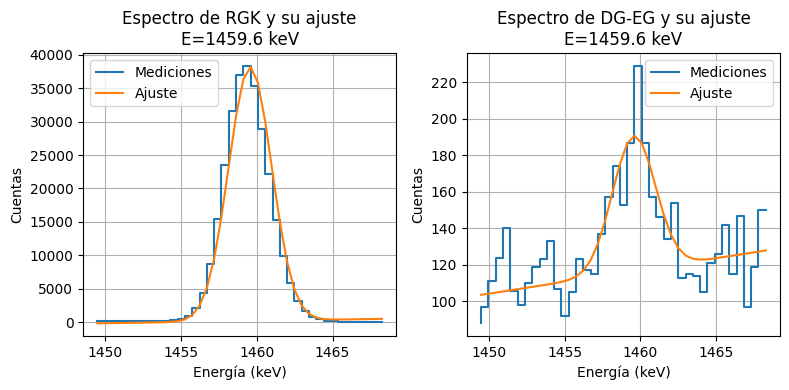

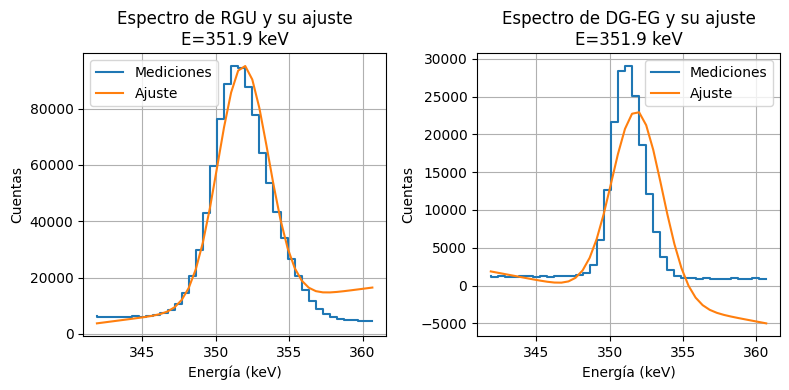

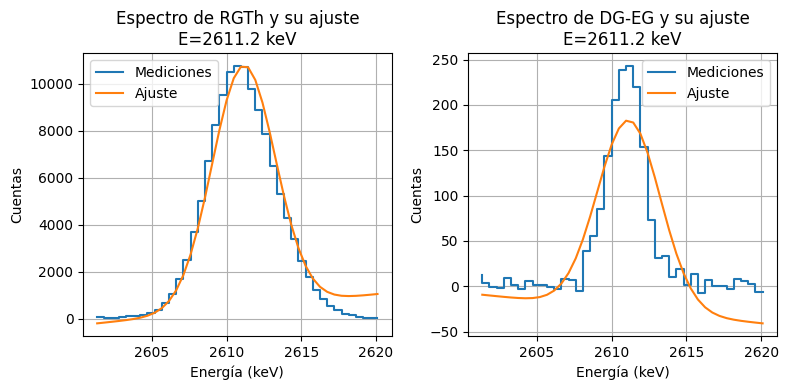

In [62]:
# plot the adjusted values of the counts for each channel
plt_range = [(int(c-20), int(c+20)) for c in p_adj['Energía (Canal)']]

e2plot = [1461, 351, 2615]
tolerance = 4  # Define your tolerance value
indices = []

for value in e2plot:
    close_values = np.isclose(p_adj_kev['Energía (keV)'], value, atol=tolerance)
    index = np.where(close_values)[0]
    if index.size > 0:
        indices.append(index[0])  # append the first index if there are multiple

print(list(indices))
e2plot = p_adj_kev['Energía (keV)'][indices]
for i in indices:
    x = e_puro['Canal'][plt_range[i][0]:plt_range[i][1]]
    ex = e_puro['Energía (keV)'][plt_range[i][0]:plt_range[i][1]]
    e = round(a_0+a_1*p_adj['Energía (Canal)'][i],1)
    y1a = e_puro[nombre_datos[int(n_ref[i]-1)]][plt_range[i][0]:plt_range[i][1]]
    y2a = gaussiana_lineal(x, *popt2[i])
    y1b = e_puro[nombre_datos[-2]][plt_range[i][0]:plt_range[i][1]]
    y2b = gaussiana_lineal(x, *popt3[i])

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot y1a and y2a on the first subplot
    axs[0].step(ex, y1a, label='Mediciones')
    axs[0].plot(ex, y2a, label='Ajuste')
    axs[0].set_title(f'Espectro de {nombre_datos[int(n_ref[i]-1)]} y su ajuste\nE={e} keV')
    axs[0].set_xlabel('Energía (keV)')
    axs[0].set_ylabel('Cuentas')
    axs[0].legend()
    axs[0].grid()

    # Plot y1b and y2b on the second subplot
    axs[1].step(ex, y1b, label='Mediciones')
    axs[1].plot(ex, y2b, label='Ajuste')
    axs[1].set_title(f'Espectro de {nombre_datos[-2]} y su ajuste\nE={e} keV')
    axs[1].set_xlabel('Energía (keV)')
    axs[1].set_ylabel('Cuentas')
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()

## Punto 2

Función para el calculo de la intensidad.
```python
# integral de la gaussiana
def integ_riemman(x,y):
    integral = 0
    dx = x[1]-x[0]
    for i in range(len(x)):
        integral = integral + dx*y[i]
    return integral
def integ_riemman_incert(x, y, dx_uncertainty, y_uncertainty):
    integral_uncertainty = 0
    dx = x[1] - x[0]
    for i in range(len(x)):
        # term_uncertainty = ((dx * y_uncertainty[i]) ** 2 + (y[i] * dx_uncertainty) ** 2) ** 0.5
        term_uncertainty = ((dx * y_uncertainty) ** 2 + (y[i] * dx_uncertainty) ** 2) ** 0.5
        integral_uncertainty += term_uncertainty ** 2
    return integral_uncertainty ** 0.5

sigmas = 2
rango_integracion = [(int(p_adj_kev['Energía (keV)'][i]-sigmas*p_adj_kev['sigma (keV)'][i]), int(p_adj_kev['Energía (keV)'][i]+sigmas*p_adj_kev['sigma (keV)'][i])) for i in indices]
integral = []
integral2 = []
d_integral = []
d_integral2 = []
for i in range(len(e2plot)):
    j = indices[i]
    x = list(e_puro['Energía (keV)'][rango_integracion[i][0]:rango_integracion[i][1]])
    y = list(e_puro[nombre_datos[int(n_ref[j]-1)]][rango_integracion[i][0]:rango_integracion[i][1]])
    y2 = list(e_puro[nombre_datos[-2]][rango_integracion[i][0]:rango_integracion[i][1]])
    integral.append(integ_riemman(x,y)) 
    integral2.append(integ_riemman(x,y2))
    d_integral.append(integ_riemman_incert(x,y,0.1,0.1))
    d_integral2.append(integ_riemman_incert(x,y2,0.1,0.1))

Ir = integral
dIr = d_integral
Im = integral2
dIm = d_integral2


```
Descartada debido a calculo más simple encontrado.
$I = \sqrt{2\pi}\sigma M$

In [63]:
kn = np.sqrt(2*np.pi)
Ir = [(kn*M*s/a_1) for M, s in zip(p_adj['A (cuentas)'][indices], p_adj_kev['sigma (keV)'][indices])]
dIr = [kn/a_1*((M*ds**2)+(s*dM**2))**0.5 for M, s, dM, ds in zip(p_adj['A (cuentas)'][indices], p_adj_kev['sigma (keV)'][indices], p_adj['dA (cuentas)'][indices], p_adj_kev['dsigma (keV)'][indices])]
Im = [(kn/a_1*M*s) for M, s in zip(p_adj['DG-EG A (cuentas)'][indices], p_adj_kev['DG-EG sigma (keV)'][indices])]
dIm = [kn/a_1*((M*ds**2)+(s*dM**2))**0.5 for M, s, dM, ds in zip(p_adj['DG-EG A (cuentas)'][indices], p_adj_kev['DG-EG sigma (keV)'][indices], p_adj['DG-EG dA (cuentas)'][indices], p_adj_kev['DG-EG dsigma (keV)'][indices])]

## Punto 4

In [64]:
resultados = pd.DataFrame()
resultados['Fuente'] = p_adj['Fuente'][indices]
resultados['Energía (keV)'] = e2plot.apply(lambda x: f"{x:.2f}") + " (" + p_adj_kev['dE (keV)'][indices].apply(lambda x: f"{int(x*100)+1}") + ")"
resultados['sigma (keV)'] = [f"{a:.2f} ({int(b*100)+1})" for a,b in zip(p_adj_kev['sigma (keV)'][indices].values,p_adj_kev['dsigma (keV)'][indices].values)]
resultados['Mr (cuentas/canal)'] = [f"{a:.0f} ({int(b)+1})" for a,b in zip(p_adj['A (cuentas)'][indices], p_adj['dA (cuentas)'][indices])]
resultados['Ir (cuentas)'] = [f"{a:.0f} ({int(b)+1})" for a,b in zip(Ir, dIr)]
resultados['Mm (cuentas/canal)'] = [f"{a:.0f} ({int(b)+1})" for a,b in zip(p_adj['DG-EG A (cuentas)'][indices], p_adj['DG-EG dA (cuentas)'][indices])]
resultados['Im (cuentas)'] = [f"{x:.0f} ({int(dx)+1})" for x, dx in zip(Im, dIm)]
resultados

,Fuente,Energía (keV),sigma (keV),Mr (cuentas/canal),Ir (cuentas),Mm (cuentas/canal),Im (cuentas)
51,RGK,1460.57 (2),1.42 (2),38050 (308),281605 (1908),74 (10),544 (60)
12,RGU,352.86 (4),1.72 (4),84836 (1252),760521 (8556),24859 (2095),221553 (14276)
74,RGTh,2612.15 (4),2.12 (4),10323 (123),114064 (929),209 (21),2298 (158)


## Punto 5, 6 y 7

De % a ppm es,
$$x\,[\mathrm{ppm}] = x\, [\%] \frac{1}{100\,[\%]} 10^6 \,[\mathrm{ppm}]$$

La concentración se calcula como, $$C_m(\mathrm{K}) = \frac{I_m}{I_r}C_r(\mathrm{K})$$

In [65]:
Cr = [0.448*1e6,800,400]
dCr = [0.003*1e6,16,0.2]
Cm = [x/y*z for x,y,z in zip(Im,Ir,Cr)]
dCm = [1/y*((z*dx)**2+(x*dz)**2+(-x*z*dy/y)**2)**0.5 for x,y,z,dx,dy,dz in zip(Im,Ir,Cr,dIm,dIr,dCr)]
resultados['Cm (ug/g)'] = [f"{x:.2f} ({int(y*100)+1})" for x,y in zip(Cm,dCm)]
resultados

,Fuente,Energía (keV),sigma (keV),Mr (cuentas/canal),Ir (cuentas),Mm (cuentas/canal),Im (cuentas),Cm (ug/g)
51,RGK,1460.57 (2),1.42 (2),38050 (308),281605 (1908),74 (10),544 (60),866.20 (9475)
12,RGU,352.86 (4),1.72 (4),84836 (1252),760521 (8556),24859 (2095),221553 (14276),233.05 (1595)
74,RGTh,2612.15 (4),2.12 (4),10323 (123),114064 (929),209 (21),2298 (158),8.06 (56)


$m = $```m``` es la masa de la muestra.

$\varphi=$```phi``` es la abundancia isotópica.

La actividad $A_m=$```Am``` para el potasio de la muestra es:
$$A = \frac{0.693 N_A}{T_{1/2}w(\mathrm{K})} \varphi (^{40}\mathrm{K}) C(\mathrm{K})m$$

## Punto 8

In [66]:
n_phi = ['40K', '238U', '232Th']
phi = [0.000117, 0.992742,1]
w = [39.0983, 238.02891, 232.0377]
T12 = [1.247e9, 4.47e9, 1.40e10]
# Pasar vida media a segundos
T12 = [t*365*24*60*60 for t in T12]

m = 500
NA = 6.02214076e23

# Calcular actividad
A = [0.693*NA*c*d/(a*b*1e6)*m for a,b,c,d in zip(T12,w,phi,Cm)]
dA = [0.693*NA*c*m/(a*b*1e6)*((dd/d)**2)**0.5 for a,b,c,d,dd in zip(T12,w,phi,Cm,dCm)]

resultados['Am (Bq)'] = [f"{x:.2f} ({int(y*100)+1})" for x,y in zip(A,dA)]
resultados

,Fuente,Energía (keV),sigma (keV),Mr (cuentas/canal),Ir (cuentas),Mm (cuentas/canal),Im (cuentas),Cm (ug/g),Am (Bq)
51,RGK,1460.57 (2),1.42 (2),38050 (308),281605 (1908),74 (10),544 (60),866.20 (9475),13.75 (1)
12,RGU,352.86 (4),1.72 (4),84836 (1252),760521 (8556),24859 (2095),221553 (14276),233.05 (1595),1438.81 (43)
74,RGTh,2612.15 (4),2.12 (4),10323 (123),114064 (929),209 (21),2298 (158),8.06 (56),16.41 (15)


## Punto 9 y 10

Se desarrollaron en simultaneo con el pico de 40K